In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data.csv', index_col='date_local')
df.head(100)

,co,pm10,o3,f0_
date_local,,,,
2000-01-01,0.455556,20.0,0.023588,27
2000-01-07,1.179167,53.0,0.011882,49
2000-01-13,1.229167,23.0,0.004529,21
2000-01-19,1.041667,14.0,0.011588,17
2000-01-25,0.825000,11.0,0.016353,20
...,...,...,...,...
2001-07-30,0.504167,9.0,0.010235,10
2001-08-05,0.416667,10.0,0.014647,17
2001-08-11,0.500000,9.0,0.025882,26


<AxesSubplot:xlabel='date_local'>

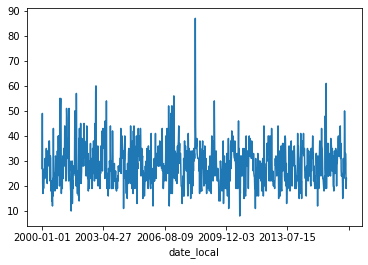

In [3]:
df['f0_'].plot()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 994 entries, 2000-01-01 to 2019-12-23
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co      994 non-null    float64
 1   pm10    994 non-null    float64
 2   o3      994 non-null    float64
 3   f0_     994 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 38.8+ KB


In [5]:
from sklearn.model_selection import train_test_split


In [6]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)

	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [7]:
df_transformed = series_to_supervised(df, 5, 1, False)

In [8]:
X = df.iloc[:,1:-1].values
y = df.iloc[:, -1].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=0, shuffle=False)

In [10]:
print(X_train)

[[2.0000e+01 2.3588e-02]
 [5.3000e+01 1.1882e-02]
 [2.3000e+01 4.5290e-03]
 ...
 [7.0000e+00 2.5882e-02]
 [2.6000e+01 7.0590e-03]
 [8.0000e+00 2.5412e-02]]


In [11]:
# Scale the independent variables
from sklearn.preprocessing import StandardScaler
scalerX = StandardScaler().fit(X_train)
X_train_scaled = scalerX.transform(X_train)
X_test_scaled = scalerX.transform(X_test)

In [12]:
import xgboost
reg = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=1000, nthread=24)
reg.fit(X_train_scaled, y_train)

/Users/mikec/Library/Python/3.8/lib/python/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=24,
             nthread=24, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
predictions_xgb = reg.predict(X_test_scaled)
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_xgb = sqrt(mean_squared_error(y_test, predictions_xgb))
print("XGBoost - Root Mean Square Error (RMSE): %.3f" % rmse_xgb)

XGBoost - Root Mean Square Error (RMSE): 4.214


In [14]:
df

,co,pm10,o3,f0_
date_local,,,,
2000-01-01,0.455556,20.0,0.023588,27
2000-01-07,1.179167,53.0,0.011882,49
2000-01-13,1.229167,23.0,0.004529,21
2000-01-19,1.041667,14.0,0.011588,17
2000-01-25,0.825000,11.0,0.016353,20
...,...,...,...,...
2019-11-05,0.400000,24.0,0.024353,25
2019-11-17,0.608333,23.0,0.018824,33
2019-11-29,0.283333,10.0,0.020941,29


In [15]:
df_time_series = pd.concat([df.shift(1), df], axis=1)

In [16]:
df_time_series.dropna()

,co,pm10,o3,f0_,co,pm10,o3,f0_
date_local,,,,,,,,
2000-01-07,0.455556,20.0,0.023588,27.0,1.179167,53.0,0.011882,49
2000-01-13,1.179167,53.0,0.011882,49.0,1.229167,23.0,0.004529,21
2000-01-19,1.229167,23.0,0.004529,21.0,1.041667,14.0,0.011588,17
2000-01-25,1.041667,14.0,0.011588,17.0,0.825000,11.0,0.016353,20
2000-01-31,0.825000,11.0,0.016353,20.0,0.804167,21.0,0.011824,19
...,...,...,...,...,...,...,...,...
2019-11-05,0.470833,42.0,0.016000,39.0,0.400000,24.0,0.024353,25
2019-11-17,0.400000,24.0,0.024353,25.0,0.608333,23.0,0.018824,33
2019-11-29,0.608333,23.0,0.018824,33.0,0.283333,10.0,0.020941,29


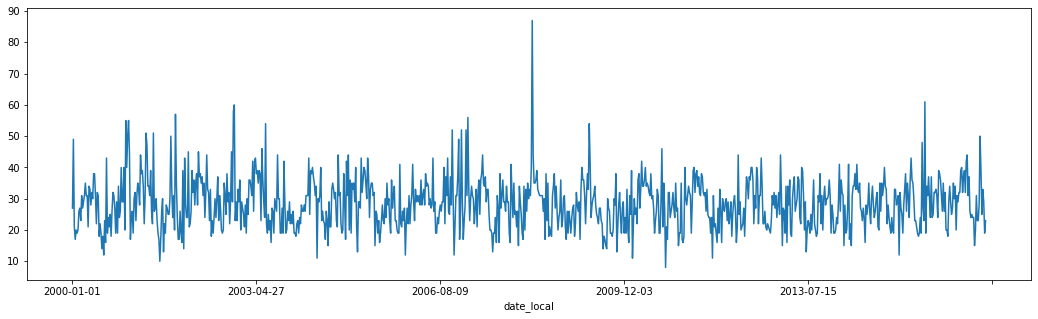

In [17]:
df['f0_'].plot(figsize=(18, 5));

In [20]:
X = df_time_series.iloc[:,0:-1].values
y = df_time_series.iloc[:, -1].values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]

IndexingError: Too many indexers

Observations: 994
Training Observations: 656
Testing Observations: 338


/Users/mikec/Library/Python/3.8/lib/python/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

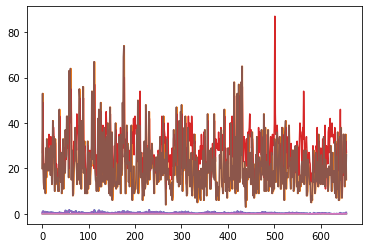

In [ ]:
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
plt.plot(train)
plt.plot([None for i in train] + [x for x in test])
plt.show()